In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from projects.iam.energy_system import LogitEnergySystem

warnings.filterwarnings("ignore")
%load_ext jupyter_black

In [2]:
wes = LogitEnergySystem(
    "/Users/lindseygulden/dev/leg-up-private/projects/iam/config.yml"
)
wes.simulate()

INFO:root: >>> Simulating 2025 (timestep 0)
INFO:root: >>> Simulating 2030 (timestep 1)
INFO:root: >>> Simulating 2035 (timestep 2)
INFO:root: >>> Simulating 2040 (timestep 3)
INFO:root: >>> Simulating 2045 (timestep 4)
INFO:root: >>> Simulating 2050 (timestep 5)
INFO:root: >>> Simulating 2055 (timestep 6)
INFO:root: >>> Simulating 2060 (timestep 7)
INFO:root: >>> Simulating 2065 (timestep 8)
INFO:root: >>> Simulating 2070 (timestep 9)
INFO:root: >>> Simulating 2075 (timestep 10)


In [3]:
pd.DataFrame(wes.carbon_flow_kg_per_mwh["atmosphere"]).T

,renewables,oil,ng
0,0.210000,98.800000,82.820000
1,0.370361,45.314063,90.325883
2,0.527250,16.776244,78.008696
3,0.658781,5.590423,58.189165
4,0.762801,1.812431,38.135044
5,0.840801,0.582225,21.718502
6,0.896359,0.187739,11.434346
7,0.934099,0.061091,6.101718
8,0.958592,0.019523,3.239506
9,0.974056,0.005964,1.748829


In [5]:
pd.DataFrame(wes.ccs_usd_per_mwh)

,0,1,2,3,4,5,6,7,8,9,10,11
eor,0,0.0,0.09934,0.267176,0.383622,0.502266,0.59924,0.561322,0.429773,0.306584,0.209231,0.141808
gs,0,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


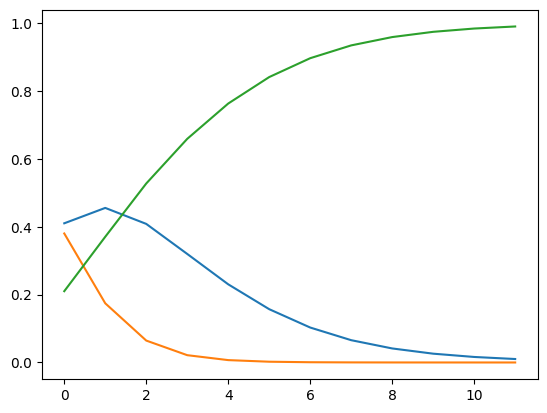

In [7]:
# plt.plot(pd.DataFrame(wes.adjusted_cost_energy_usd_per_mwh).T)
plt.plot(pd.DataFrame(wes.energy_shares).T)
# plt.plot(pd.DataFrame(wes.ccs_totals)[["ccs-eor kgco2", "ccs-gs kgco2"]])

In [5]:
import pyreadr

result = pyreadr.read_r("/Volumes/Samsung_T5/data/iam/GCAM_DATA_MAP.rda")
p = pyreadr.read_r("/Volumes/Samsung_T5/data/iam/PREBUILT_DATA.rda")
# done! let's see what we got
# print(result.keys()) # let's check what objects we got
# df1 = result["df1"] # extract the pandas data frame for object df1

In [ ]:
pyreadr.list_objects("/Volumes/Samsung_T5/data/iam/GCAM_DATA_MAP.rda")

In [ ]:
pd.read_xml("/Users/lindseygulden/dev/leg-up-private/data/ccs_supply_low.xml")

In [ ]:
import numpy as np
from scipy.optimize import fsolve


def multinomial_logit_partial_eq_energy_with_tax(
    beta, attrs_options, supply_func, demand_func, carbon_tax
):
    """
    Computes partial market equilibrium in the electricity sector using a multinomial logit choice function
    among Renewable Energy, Natural Gas, and Coal-Fired Electricity with a carbon tax.

    Parameters:
    - beta: Coefficient vector for utility (numpy array)
            Length should match the number of attributes per option.
    - attrs_options: Attributes for each option (2D numpy array)
                    Shape: (number_of_options, number_of_attributes)
    - supply_func: Function to compute supply given price
    - demand_func: Function to compute demand given price
    - carbon_tax: Carbon tax per ton of CO2 (float)

    Returns:
    - Equilibrium price
    - Market shares for each option (list)
    - Quantities sold for each option (list)
    """
    num_options = attrs_options.shape[0]

    def choice_prob(beta, attrs):
        """
        Calculates choice probabilities using the multinomial logit model with carbon tax.

        Parameters:
        - beta: Coefficient vector for utility
        - attrs: Attributes for all options (2D numpy array)

        Returns:
        - List of probabilities for each option
        """
        # Incorporate carbon tax into utility
        # Assume carbon_tax affects the effective price: Price_effective = Price + (Emissions * carbon_tax)
        price_effective = attrs[:, 0] + attrs[:, 1] * carbon_tax
        modified_attrs = np.copy(attrs)
        modified_attrs[:, 0] = price_effective  # Update price with carbon tax

        utilities = np.dot(modified_attrs, beta)
        exp_utilities = np.exp(utilities)
        sum_exp = np.sum(exp_utilities)
        probabilities = exp_utilities / sum_exp
        return probabilities

    def equilibrium(price):
        """
        Equilibrium condition: Total Supply = Total Demand

        Parameters:
        - price: Current price guess

        Returns:
        - Difference between supply and demand at this price
        """
        P = choice_prob(beta, attrs_options)
        Q_demand = demand_func(price)
        Q_supply = supply_func(price)
        return Q_supply - Q_demand

    # Initial guess for price
    initial_price = 50.0  # Example initial price in $/MWh

    # Solve for equilibrium price
    (eq_price,) = fsolve(equilibrium, initial_price)

    # Compute final market shares and quantities
    P = choice_prob(beta, attrs_options)
    Q_demand_eq = demand_func(eq_price)
    Q_supply_eq = supply_func(eq_price)

    # Quantities sold for each option based on market share
    Q = P * Q_demand_eq

    return eq_price, P.tolist(), Q.tolist()


# Example Usage with Carbon Tax
if __name__ == "__main__":
    # Coefficients for utility
    # [Price Coef, Emissions Coef, Reliability Coef]
    beta = np.array([-0.04, -0.03, 0.05])  # Example coefficients

    # Attributes: [Price ($/MWh), Emissions (tons CO2/MWh), Reliability (0 to 1)]
    attrs_options = np.array(
        [
            [50.0, 0.0, 0.9],  # Renewable Energy
            [45.0, 0.35, 0.95],  # Natural Gas
            [30.0, 0.8, 0.85],  # Coal-Fired Electricity
        ]
    )

    # Define supply and demand functions
    def supply(price):
        """Simple linear supply function: Q = a * price"""
        a = 2.0  # Supply elasticity
        return a * price  # Supply in MWh

    def demand(price):
        """Simple linear demand function: Q = b - c * price"""
        b = 200.0  # Base demand
        c = 4.0  # Price sensitivity
        return b - c * price  # Demand in MWh

    # Define carbon tax (e.g., $20 per ton of CO2)
    carbon_tax = 0  # $/ton CO2

    # Compute equilibrium
    eq_price, market_shares, quantities = multinomial_logit_partial_eq_energy_with_tax(
        beta, attrs_options, supply, demand, carbon_tax
    )

    # Define option names for clarity
    option_names = ["Renewable Energy", "Natural Gas", "Coal-Fired Electricity"]

    # Display Results
    print(f"Equilibrium Price: ${eq_price:.2f}/MWh\n")
    for i, name in enumerate(option_names):
        print(f"Market Share {name}: {market_shares[i]*100:.2f}%")
    print()
    for i, name in enumerate(option_names):
        print(f"Quantity Sold {name}: {quantities[i]:.2f} MWh")

In [ ]:
2**2

In [82]:
# https://www.eia.gov/tools/faqs/faq.php?id=427&t=3
energy_shares = {
    "solar": 0.08,
    "wind": 0.12,
    "coal": 0.16,
    "ng": 0.43,
    "nuclear": 0.19,
}
# https://en.wikipedia.org/wiki/Cost_of_electricity_by_source#/media/File:20201019_Levelized_Cost_of_Energy_(LCOE,_Lazard)_-_renewable_energy.svg

energy_costs_cents_per_kwh = {
    "solar": 6,
    "wind": 5,
    "coal": 12,
    "ng": 7,
    "nuclear": 18,
}
outvals = {"solar": [], "wind": [], "coal": [], "ng": [], "nuclear": [], "gamma": []}
for v in range(-100, 100):
    t = v / 10
    outvals["gamma"] = outvals["gamma"] + [t]
    tmp = logit_share(
        labels=list(energy_shares.keys()),
        alpha=list(energy_shares.values()),
        costs=list(energy_costs_cents_per_kwh.values()),
        gamma=t,
    )
    for k, v in tmp.items():
        outvals[k] = outvals[k] + [v]
df = pd.DataFrame(outvals)
df = df.melt(id_vars="gamma", value_name="share", var_name="energy")

In [88]:
energy_costs_cents_per_kwh = {
    "solar": 6,
    "wind": 5,
    "coal": 12,
    "ng": 5,
    "nuclear": 18,
}
outvals = {"solar": [], "wind": [], "coal": [], "ng": [], "nuclear": [], "gamma": []}
for v in range(-100, 100, 1):
    t = v / 10
    outvals["gamma"] = outvals["gamma"] + [t]
    tmp = logit_share(
        labels=list(energy_shares.keys()),
        alpha=list(energy_shares.values()),
        costs=list(energy_costs_cents_per_kwh.values()),
        gamma=t,
    )
    for k, v in tmp.items():
        outvals[k] = outvals[k] + [v]
df_ff_cheap = pd.DataFrame(outvals)
df_ff_cheap = df_ff_cheap.melt(id_vars="gamma", value_name="share", var_name="energy")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.lineplot(data=df, x="gamma", y="share", hue="energy", ax=ax[0])
ax[0].grid()
ax[0].set_xlabel("Logit exponent for choice function")
ax[0].set_title("Standard price per kwh")

sns.lineplot(data=df_ff_cheap, x="gamma", y="share", hue="energy", ax=ax[1])
ax[1].grid()
ax[1].set_title("Slightly cheaper natural gas")
ax[1].set_xlabel("Logit exponent for choice function")

In [26]:
# https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2021/Jun/IRENA_Power_Generation_Costs_2020.pdf
# There are 277 kwh in a GJ
# https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.irena.org/-/media/Irena/Files/REmap/IRENA_REmap_2030_commodity_prices.xlsx&ved=2ahUKEwit6rWitaWJAxUYmokEHcP0K8QQFnoECCkQAQ&usg=AOvVaw357qYwKo_HKSnZRBKr81bD
energy_costs_usd_per_gj = {
    "renewables": 14,
    "coal": 33,
    "ng": 19,
    "ng_ccs": 19,
    "nuclear": 50,
    "oil": 10,
}

In [27]:
def logit_share(labels, alpha, costs, gamma):
    share = []
    costs = [c**gamma for c in costs]
    denominator = np.sum([a * c for a, c in zip(alpha, costs)])
    for a, c in zip(alpha, costs):
        share.append((a * c) / denominator)
    return dict(zip(labels, share))

In [34]:
# https://www.eia.gov/tools/faqs/faq.php?id=427&t=3
energy_shares = {
    "renewables": 0.09,
    "nuclear": 0.09,
    "coal": 0.09,
    "oil": 0.38,
    "ng_ccs": 0,
    "ng": 0.36,
}
# https://en.wikipedia.org/wiki/Cost_of_electricity_by_source#/media/File:20201019_Levelized_Cost_of_Energy_(LCOE,_Lazard)_-_renewable_energy.svg

energy_costs_cents_per_kwh = {
    "renewables": 5.5,
    "coal": 12,
    "ng": 7,
    "ng_ccs": 7,
    "nuclear": 18,
    "oil": 10,
}
# set up simulation timesteps
years = list(range(1, 10))

gamma = -2
outvals = {}
sources = list(energy_shares.keys())

In [ ]:
600 / 277

## Read data, compile references into a single column, remove link and single-reference columns

In [55]:
df = pd.read_excel(
    "/Users/lindseygulden/Downloads/IEA_CCUS_Projects_Database_2024.xlsx",
    sheet_name="CCUS Projects Database",
)

df[["Ref 1", "Ref 2", "Ref 3", "Ref 4", "Ref 5", "Ref 6", "Ref 7"]].fillna(
    "", inplace=True
)
df["references"] = [
    str(r1)
    + " "
    + str(r2)
    + " "
    + str(r3)
    + " "
    + str(r4)
    + " "
    + str(r5)
    + " "
    + str(r6)
    + " "
    + str(r7)
    for r1, r2, r3, r4, r5, r6, r7 in zip(
        df["Ref 1"],
        df["Ref 2"],
        df["Ref 3"],
        df["Ref 4"],
        df["Ref 5"],
        df["Ref 6"],
        df["Ref 7"],
    )
]
df.drop(
    [
        "Ref 1",
        "Ref 2",
        "Ref 3",
        "Ref 4",
        "Ref 5",
        "Ref 6",
        "Ref 7",
        "Link 1",
        "Link 2",
        "Link 3",
        "Link 4",
        "Link 5",
        "Link 6",
        "Link 7",
    ],
    axis=1,
    inplace=True,
)
df.columns = [
    x.lower().replace("(", "").replace(")", "").replace("/", "_per_").replace(" ", "_")
    for x in df.columns.values
]

In [56]:
len(df)

844

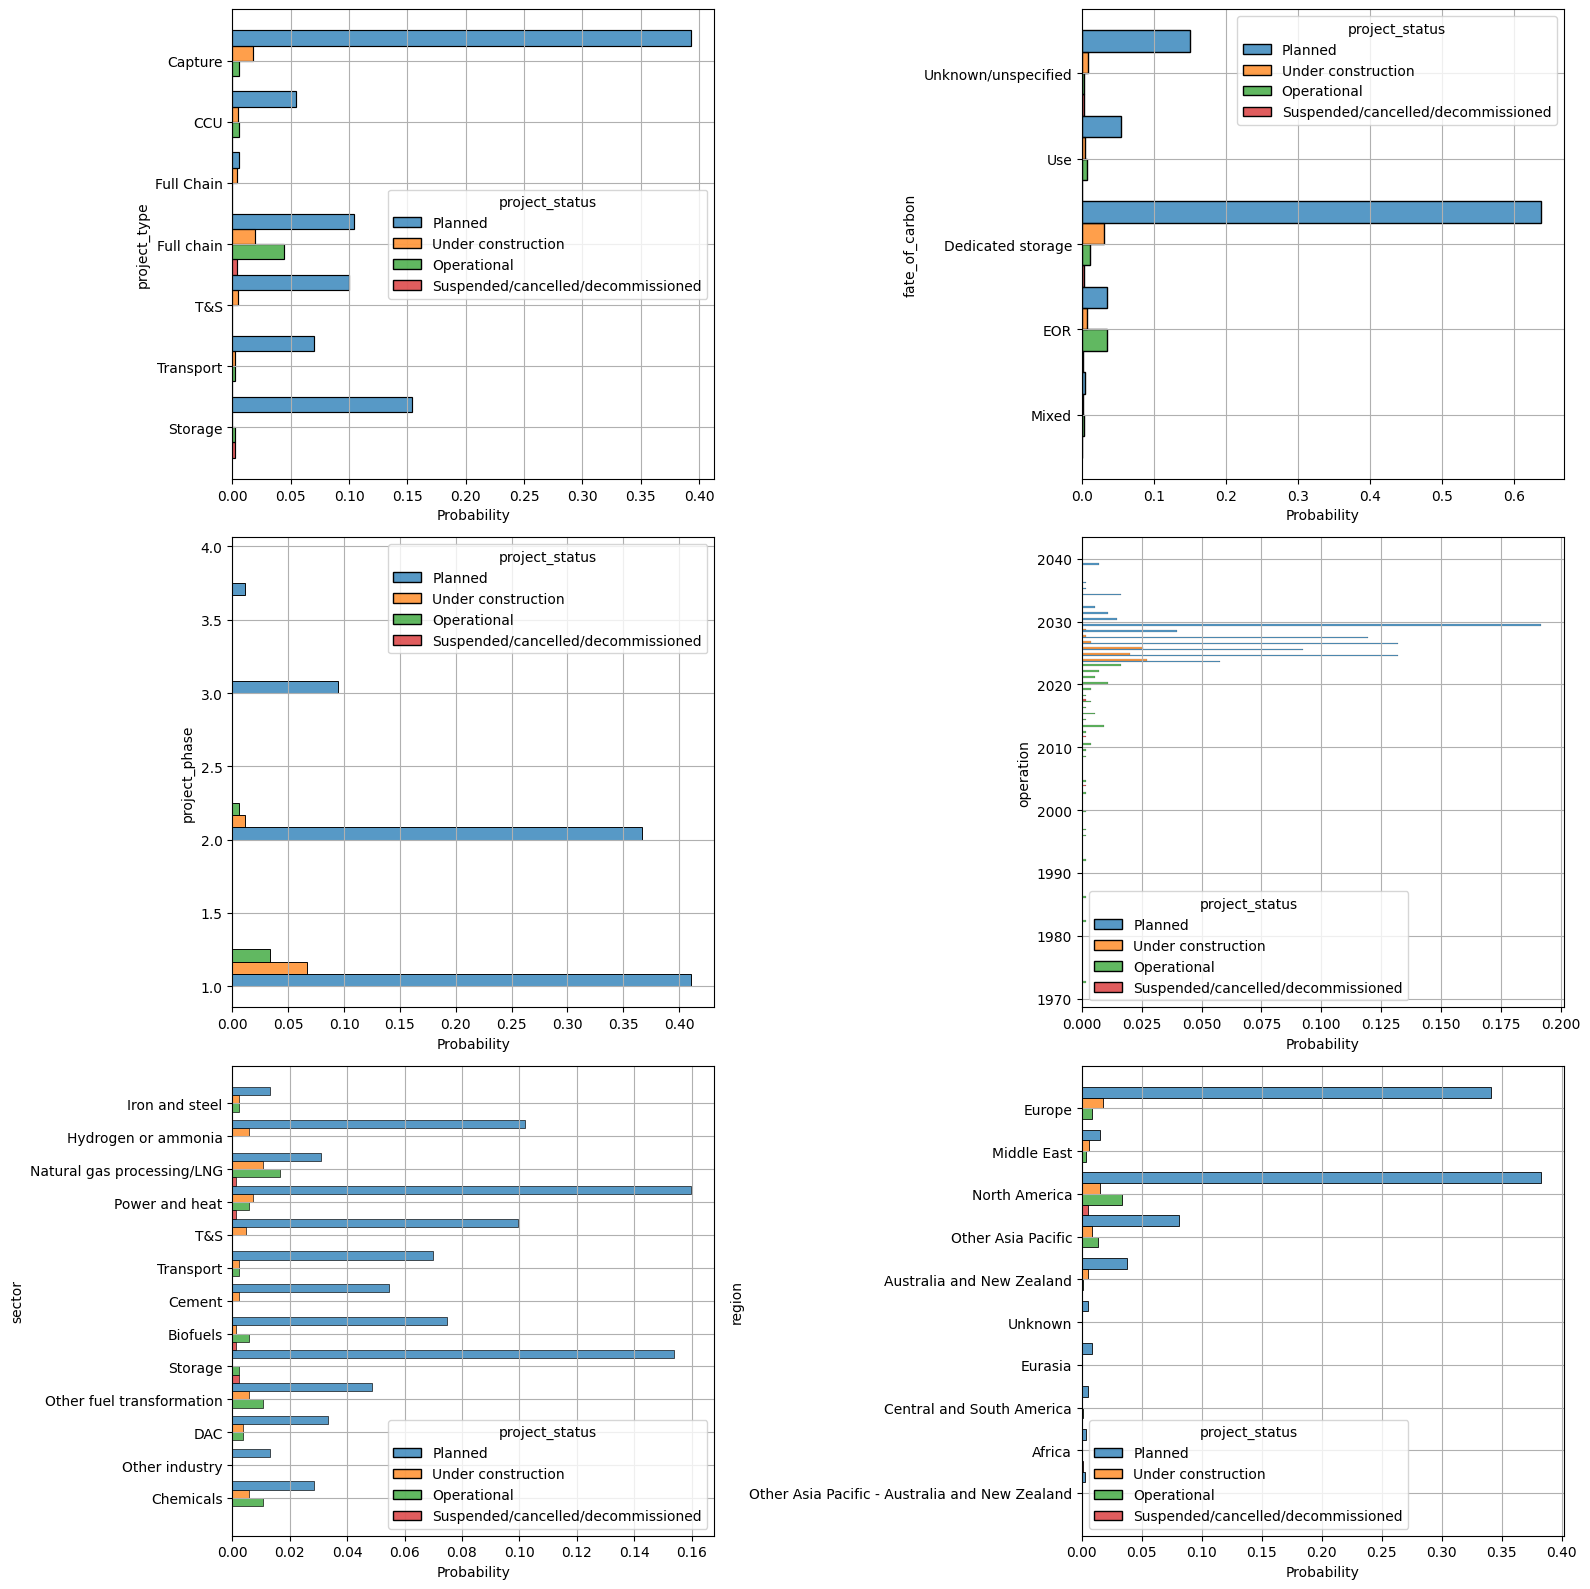

In [57]:
cols = [
    "project_type",
    "fate_of_carbon",
    "project_phase",
    "operation",
    "sector",
    "region",
]
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
for i, ax in enumerate(axes.reshape(-1)):
    sns.histplot(
        data=df,
        y=cols[i],
        ax=ax,
        hue="project_status",
        multiple="dodge",
        stat="probability",
    )
    ax.grid()
fig.tight_layout()

In [1]:
# https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent#:~:text=The%20U.S.%20Internal%20Revenue%20Service,metres)%20of%20typical%20natural%20gas.
gj_per_bbl = 6.1  # GJ in one bbl of oil
# CO2 EOR recovery factor
bbl_per_tco2 = 3
usd_per_tco2 = 60


gj_per_tco2 = gj_per_bbl * bbl_per_tco2
subsidy_usd_per_gj = usd_per_tco2 / gj_per_tco2
subsidy_usd_per_gj

3.2786885245901645

ValueError: Could not interpret value `year` for parameter `x`

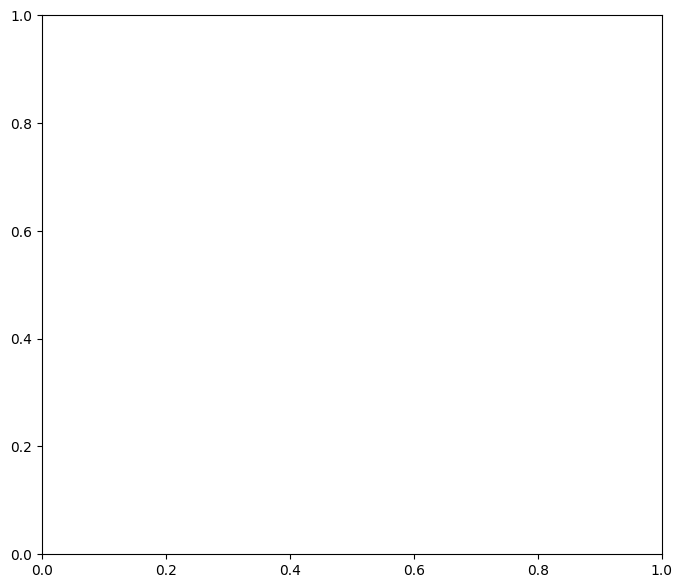

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.lineplot(data=df, x="year", y="share", hue="energy", ax=ax)
ax.grid()
ax.set_xlabel("Year")
ax.set_title("Standard price paer kwh")

In [60]:
def compute_carbon_flux(
    reservoirs: dict,
    shares: dict,
    intensity: dict,
    capture_frac: dict,
    ccs_prevalence_frac: float,
) -> dict:
    sources = list(shares.keys())
    carbon_flux = {}
    co2_captured = {}
    for s in sources:
        co2_captured[s] = (
            ccs_prevalence_frac * capture_frac[s] * shares[s] * intensity[s]
        )
        carbon_flux[s] = shares[s] * intensity[s] - co2_captured[s]

    reservoirs["atmosphere"] = reservoirs["atmosphere"] + np.sum(
        list(carbon_flux.values())
    )
    reservoirs["ccs"] = reservoirs["ccs"] + np.sum(list(co2_captured.values()))

    return carbon_flux, co2_captured, reservoirs


def adjust_price(usd_per_mwh, extra_mwh):
    return usd_per_mwh / (1 + extra_mwh)


def ccs_adjusted_prices(
    energy_costs_usd_per_mwh, ccs_kgco2, eor_frac, eor_recovery_factor_mwh_per_kgco2
):
    return_cost_dict = energy_costs_usd_per_mwh.copy()
    new = adjust_price(
        return_cost_dict["oil"],
        ccs_kgco2 * eor_frac * eor_recovery_factor_mwh_per_kgco2,
    )
    return_cost_dict["oil"] = new
    return return_cost_dict

In [61]:
testdict = {"a": [1, 1, 1, 1], "b": [2, 2, 2, 2]}

In [62]:
# co2 tracking

carbon_intensity_kg_per_mwh = {"renewables": 1, "ng": 202, "nuclear": 1, "oil": 260}

energy_shares = {
    "renewables": 0.09,
    "nuclear": 0.09,
    "oil": 0.38,
    "ng": 0.36,
}
capture_frac = {
    "renewables": 0,
    "nuclear": 0,
    "oil": 0,
    "ng": 0.9,
}
reservoirs = {"atmosphere": 1000, "ccs": 0, "underground": 10000}

# https://en.wikipedia.org/wiki/Cost_of_electricity_by_source#/media/File:20201019_Levelized_Cost_of_Energy_(LCOE,_Lazard)_-_renewable_energy.svg

energy_costs_usd_per_mwh = {
    "renewables": 35,
    "ng": 20,
    "nuclear": 32,
    "oil": 47,
}

In [63]:
# One barrel of oil contains about 1.7 MWh of energy
oil_mwh_per_bbl = 1.7
# one thousand kilograms in a metric ton
kgco2_per_tco2 = 1000
# one barrel of oil contains about 468 kg of CO2 (0.468 tCO2)
eor_recovery_factor_bbl_per_tco2 = 3

# compute recovery factors for eor with co2 in various units
eor_recovery_factor_mwh_per_tco2 = oil_mwh_per_bbl * eor_recovery_factor_bbl_per_tco2
eor_recovery_factor_mwh_per_kgco2 = eor_recovery_factor_mwh_per_tco2 / kgco2_per_tco2
eor_recovery_factor_mwh_per_kgco2

0.0050999999999999995

In [64]:
from utils.io import dict_to_yaml

ccs_prevalence = [0, 0, 0.05, 0.1, 0.2, 0.35, 0.5, 0.6, 0.7, 0.75, 0.8]
eor_frac = [x / 100 for x in list(range(0, 25, 2))]
# set up simulation timesteps
years = list(range(0, 11))
dict_to_yaml(
    {
        "sources": sources,
        "years": years,
        "energy_shares": energy_shares,
        "capture_frac": capture_frac,
        "carbon_intensity_kg_per_mwh": carbon_intensity_kg_per_mwh,
        "energy_costs_usd_per_mwh": energy_costs_usd_per_mwh,
        "ccs_prevalence": ccs_prevalence,
        "eor_frac": eor_frac,
        "recovery_factor": eor_recovery_factor_bbl_per_tco2,
        "oil_mwh_per_bbl": oil_mwh_per_bbl,
    },
    "tmp.yml",
)

NameError: name 'sources' is not defined

In [65]:
c_flux, co2_captured, reservoirs = compute_carbon_flux(
    reservoirs,
    energy_shares,
    carbon_intensity_kg_per_mwh,
    capture_frac,
    ccs_prevalence_frac=0.5,
)
new_prices = ccs_adjusted_prices(
    energy_costs_usd_per_mwh,
    reservoirs["ccs"],
    eor_frac,
    eor_recovery_factor_mwh_per_kgco2,
)
print(f"Reservoirs are: ")
print(reservoirs)
print("")
print(f"Carbon fluxes are: ")
print(c_flux)
print("")
print(f"Co2 captured: ")
print(co2_captured)
print("")
print(f"old prices:")
print(energy_costs_usd_per_mwh)
print("")
print("New prices:")
print(new_prices)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
# get list of energy sources
sources = list(energy_shares.keys())
print(sources)
outvals = {}
for source in sources:
    outvals = outvals | {source: []}
outvals = outvals | {"year": []}
print(outvals)

for i, y in enumerate(years):
    outvals["year"] = outvals["year"] + [y]

    c_flux, co2_captured, reservoirs = compute_carbon_flux(
        reservoirs,
        energy_shares,
        carbon_intensity_kg_per_mwh,
        capture_frac,
        ccs_prevalence[i],
    )

    new_shares = logit_share(
        labels=list(energy_shares.keys()),
        alpha=list(energy_shares.values()),
        costs=list(energy_costs_usd_per_mwh.values()),
        gamma=gamma,
    )
    new_costs = ccs_adjusted_prices(
        energy_costs_usd_per_mwh,
        reservoirs["ccs"],
        eor_frac[i],
        eor_recovery_factor_mwh_per_kgco2,
    )
    energy_costs_usd_per_mwh = new_costs.copy()
    for k, v in new_shares.items():
        outvals[k] = outvals[k] + [v]
    energy_shares = new_shares
    new_shares = {}

df = pd.DataFrame(outvals)
df = df.melt(id_vars="year", value_name="share", var_name="energy")

In [ ]:
df

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.lineplot(data=df, x="year", y="share", hue="energy", ax=ax)
ax.grid()
ax.set_xlabel("Year")
ax.set_title("Standard price paer kwh")